In [13]:
from dateutil.parser import parse
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})

df=pd.read_csv('../beans-with-dollar.csv')



In [14]:
df = df.reset_index()
df = df[['Date', 'Kandy']]
df = df.set_index('Date')
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

df

,Kandy
Date,
2020-01-01,310.000000
2020-01-02,274.166667
2020-01-03,238.333333
2020-01-04,202.500000
2020-01-05,166.666667
...,...
2023-12-25,555.000000
2023-12-26,565.000000
2023-12-27,575.000000


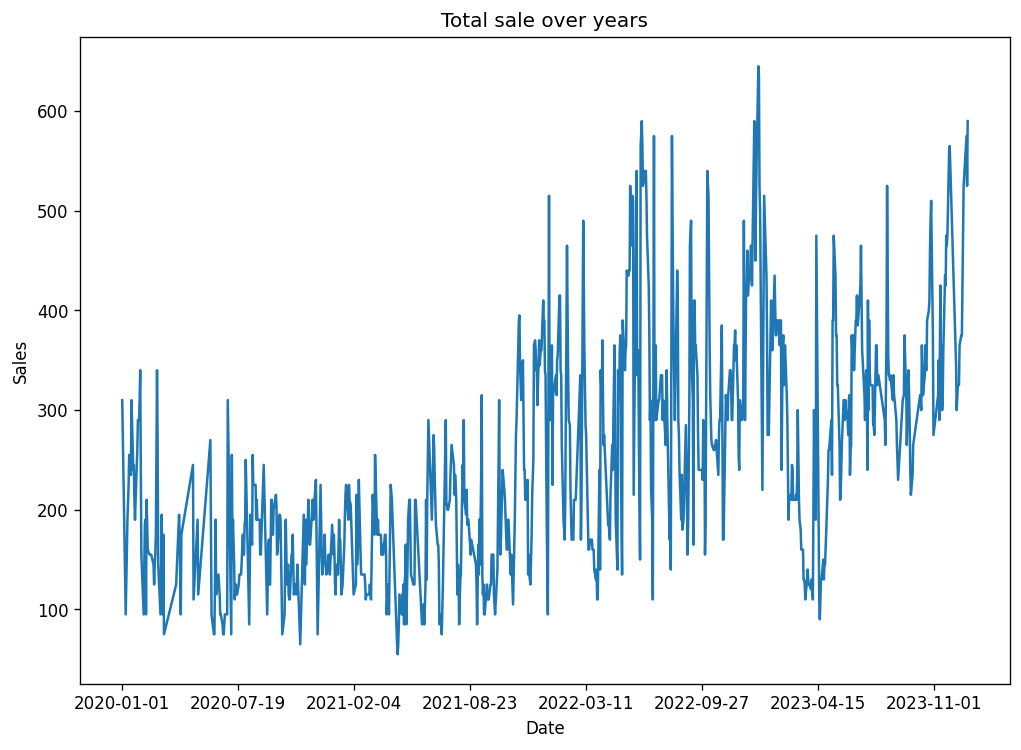

In [15]:

df['Kandy'].plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total sale over years')
plt.show()

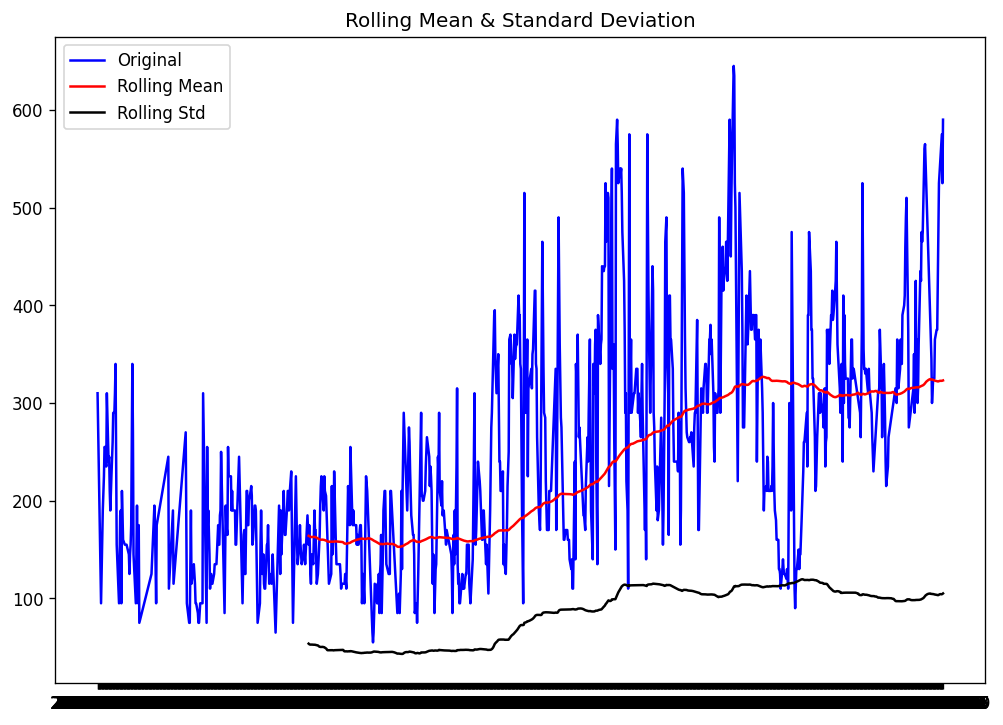

In [16]:

moving_avg = df.rolling(365).mean()
moving_std= df.rolling(365).std()
#Plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [17]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -2.166541
p-value                           0.218612
#Lags Used                       24.000000
Number of Observations Used    1434.000000
Critical Value (1%)              -3.434918
Critical Value (5%)              -2.863558
Critical Value (10%)             -2.567844
dtype: float64


In [18]:
train_size = int(0.95 * len(df))

train = df[:train_size]
test = df[train_size:]

In [19]:
import pmdarima

from pmdarima import auto_arima
auto_arima(df,test='adf',       # use adftest to find optimal 'd'
                       # maximum p and q
                                 # frequency of series
                       # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15177.072, Time=2.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=17954.404, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15200.565, Time=0.84 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16640.245, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20476.412, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=15200.498, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=15199.512, Time=2.44 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=15198.657, Time=2.68 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=15158.141, Time=3.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=15196.128, Time=1.67 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=15160.665, Time=3.54 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=15180.860, Time=1.81 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=15165.317, Time=3.28 sec
 ARIMA(2,0,3)(0,0,0)[0]  

ARIMA(order=(2, 0, 3), scoring_args={}, suppress_warnings=True)

In [20]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train, order=(2,0,3)).fit()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

In [21]:
pred= model.predict(start=len(train), end=(len(df)-1),dynamic=True)
pred

2023-10-18    354.114106
2023-10-19    342.030822
2023-10-20    331.508520
2023-10-21    323.942851
2023-10-22    318.454472
                 ...    
2023-12-25    277.198853
2023-12-26    276.850597
2023-12-27    276.505290
2023-12-28    276.162907
2023-12-29    275.823424
Freq: D, Name: predicted_mean, Length: 73, dtype: float64

In [22]:
from  sklearn.metrics import mean_absolute_percentage_error

mape= mean_absolute_percentage_error(test, pred)

print('MAPE: %f' %mape)
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE directly using root_mean_squared_error
rmse = root_mean_squared_error(test, pred)

# Print the RMSE
print('RMSE: %f' % rmse)
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test, pred)

# Print the MAE
print('MAE: %f' % mae)
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(test, pred))

# Print the RMSLE
print('RMSLE: %f' % rmsle)

MAPE: 0.260695
RMSE: 151.012962
MAE: 120.747175
RMSLE: 0.393062


In [23]:
test


,Kandy
Date,
2023-10-18,340.000000
2023-10-19,340.000000
2023-10-20,390.000000
2023-10-21,393.333333
2023-10-22,396.666667
...,...
2023-12-25,555.000000
2023-12-26,565.000000
2023-12-27,575.000000


In [24]:
pred

2023-10-18    354.114106
2023-10-19    342.030822
2023-10-20    331.508520
2023-10-21    323.942851
2023-10-22    318.454472
                 ...    
2023-12-25    277.198853
2023-12-26    276.850597
2023-12-27    276.505290
2023-12-28    276.162907
2023-12-29    275.823424
Freq: D, Name: predicted_mean, Length: 73, dtype: float64

<Axes: xlabel='Date'>

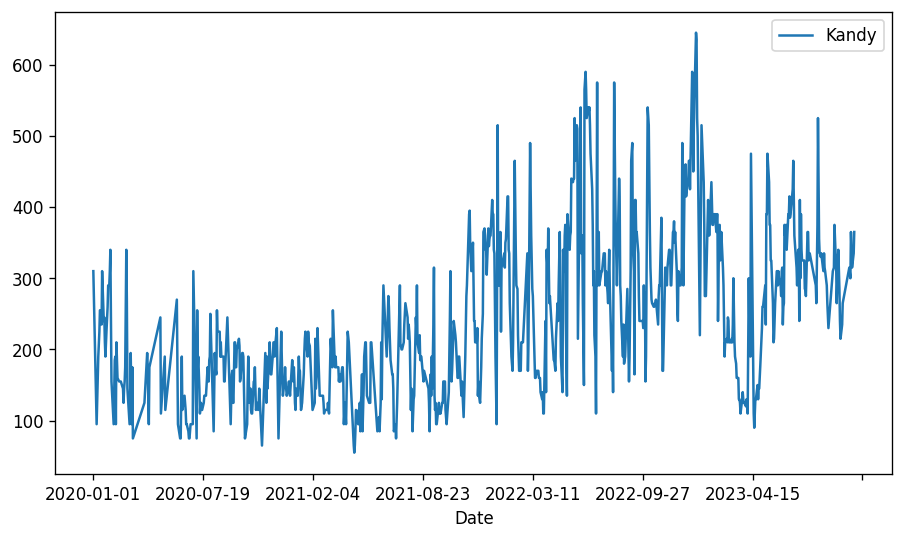

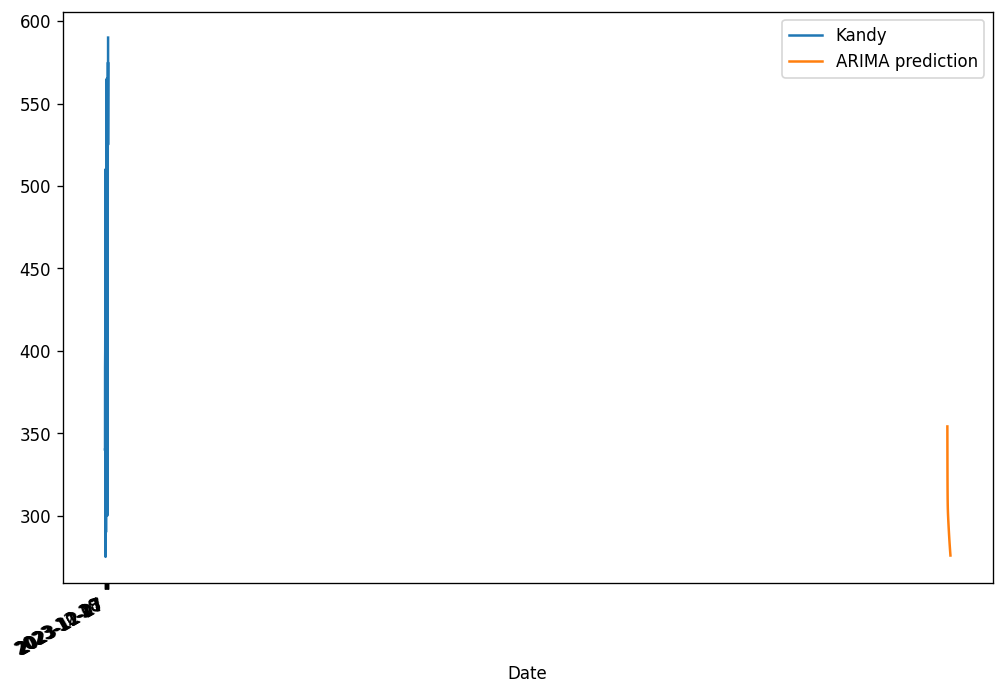

In [25]:
train.plot(legend=True, label='Train', figsize=(9,5))

test.plot(legend=True, label= 'Test')

pred.plot(legend=True, label='ARIMA prediction')